In [16]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import statistics
import tqdm
import xgboost as xgb
import graphviz

from joblib import parallel_backend
from imblearn.under_sampling import NearMiss

from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, confusion_matrix, plot_confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.preprocessing import StandardScaler
#from yellowbrick.model_selection import FeatureImportances
import matplotlib.gridspec as gridspec
from sklearn.pipeline import Pipeline
from collections import defaultdict
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Shortcut to duplicate current line

In [2]:
%%javascript

Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-shift-d', {
    help : 'Duplicate current line',
    help_index : 'zz',
    handler: function(env) {
        var cm=env.notebook.get_selected_cell().code_mirror;
        // get a position of a current cursor in a current cell
        var current_cursor = cm.doc.getCursor();

        // read a content from a line where is the current cursor
        var line_content = cm.doc.getLine(current_cursor.line);
        cm.execCommand('goLineEnd');
        cm.execCommand('newlineAndIndent');
        cm.execCommand('indentLess');
        cm.doc.replaceSelection(line_content);
        cm.doc.setCursor(current_cursor.line + 1, current_cursor.ch);
        return false;
    }}
);

<IPython.core.display.Javascript object>

#### Import data, subsample "training wheels" df for faster modelling. Create train/test splits. Create dummy variables for categorical features.

In [3]:
with open('/home/nick/Documents/data/select_cols.p', 'rb') as read_file:
    selected_columns = pickle.load(read_file)
    

tw = selected_columns.sample(50000)
ttw = selected_columns.sample(1000)
tttw = selected_columns.sample(50)

X, Xs, y, ys = selected_columns.drop(columns=['>50K', 'YRMARR', 'PWTYPE', 'BPLD', 'DEGFIELDD', 'EDUCD', 'PWMET13', 'BIRTHYR', 'SLWT', 'BPLD', 'RELATED', 'ANCESTR1D', 'EMPSTATD', 'PWMET13ERR', 'COUNTYICP']), tw.drop(columns=['>50K', 'YRMARR', 'PWTYPE', 'BPLD', 'DEGFIELDD', 'EDUCD', 'PWMET13', 'BIRTHYR', 'SLWT', 'BPLD', 'RELATED', 'ANCESTR1D', 'EMPSTATD', 'PWMET13ERR', 'COUNTYICP']), selected_columns.filter(['>50K']), tw.filter(['>50K'])
Z, Zs = selected_columns.filter(['EDUC', 'UHRSWORK', 'OCC', 'VALUEH', 'DEGFIELD', 'AGE', 'SEX', 'RACE', 'TRANWORK']), tw.filter(['EDUC', 'UHRSWORK', 'OCC', 'VALUEH', 'DEGFIELD', 'AGE', 'SEX', 'RACE', 'TRANWORK'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size=0.2, random_state=42)

train_df = X_train.copy()
train_df['$$$'] = y_train

Z_train, Z_test, q_train, q_test = train_test_split(Z, y, test_size=0.2, random_state=42)
Zs_train, Zs_test, qs_train, qs_test = train_test_split(Zs, ys, test_size=0.2, random_state=42)

# Scaling, although it seems to worsen the results for most models
std = StandardScaler()
X_train_scaled = std.fit_transform(X_train)
Xs_train_scaled = std.fit_transform(Xs_train)

Z_train_scaled = std.fit_transform(Z_train)
Zs_train_scaled = std.fit_transform(Zs_train)

edu = pd.get_dummies(Zs['EDUC'], prefix='edu')
occ = pd.get_dummies(Zs['OCC'], prefix='occ')
degfield = pd.get_dummies(Zs['DEGFIELD'], prefix='deg')
sex = pd.get_dummies(Zs['SEX'], prefix='sex', drop_first=True)
leftover = Zs.drop(columns=['EDUC', 'OCC', 'DEGFIELD', 'SEX'])
Ws = pd.concat([leftover, occ, sex, degfield, edu], axis=1)
Ws

,UHRSWORK,VALUEH,AGE,TRANWORK,occ_0.0,occ_10.0,occ_20.0,occ_40.0,occ_51.0,occ_52.0,...,edu_1.0,edu_2.0,edu_3.0,edu_4.0,edu_5.0,edu_6.0,edu_7.0,edu_8.0,edu_10.0,edu_11.0
288956,0.0,930000.0,80.0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1085020,15.0,525000.0,17.0,10.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1242904,40.0,15000.0,67.0,10.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1226428,40.0,60000.0,48.0,40.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
420714,50.0,560000.0,64.0,70.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082509,40.0,350000.0,34.0,10.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
764226,0.0,158000.0,81.0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
137567,28.0,150000.0,58.0,10.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1805513,0.0,350000.0,77.0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [4]:
edu = pd.get_dummies(Z['EDUC'], prefix='edu')
occ = pd.get_dummies(Z['OCC'], prefix='occ')
degfield = pd.get_dummies(Z['DEGFIELD'], prefix='deg')
sex = pd.get_dummies(Z['SEX'], prefix='sex', drop_first=True)
leftover = Z.drop(columns=['EDUC', 'OCC', 'DEGFIELD', 'SEX'])
W = pd.concat([leftover, occ, sex, degfield, edu], axis=1)
W

,UHRSWORK,VALUEH,AGE,TRANWORK,occ_0.0,occ_10.0,occ_20.0,occ_40.0,occ_51.0,occ_52.0,...,edu_1.0,edu_2.0,edu_3.0,edu_4.0,edu_5.0,edu_6.0,edu_7.0,edu_8.0,edu_10.0,edu_11.0
2292,40.0,130000.0,70.0,70.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2293,40.0,130000.0,71.0,10.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2294,40.0,50000.0,60.0,10.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2295,40.0,50000.0,50.0,10.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2297,0.0,50000.0,60.0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3214529,30.0,275000.0,55.0,10.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3214530,0.0,275000.0,77.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3214531,40.0,260000.0,41.0,10.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3214532,50.0,260000.0,34.0,10.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### Near Miss Undersampling to compensate for class imbalance

In [5]:
nm1 = NearMiss(version=1, sampling_strategy='auto', n_jobs=-1)
resampled_Ws, resampled_ys = nm1.fit_resample(Ws, ys)
Ws_train, Ws_test, ys_train, ys_test = train_test_split(Ws, ys, test_size=0.2, random_state=42)

In [ ]:
nm1 = NearMiss(version=1, sampling_strategy='auto', n_jobs=-1)
resampled_W, resampled_y = nm1.fit_resample(W, y)
W_train, W_test, y_train, y_test = train_test_split(W, y, test_size=0.2, random_state=42)

In [ ]:
print(len(W))
print(len(resampled_W))

print(len(Ws))
print(len(resampled_Ws))

print(len(W_train))
print(len(W_test))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(W_train, y_train)
print("Training: {:6.2f}%".format(100*knn.score(W_train, y_train)))
print("Test set: {:6.2f}%".format(100*knn.score(W_test, y_test)))

In [ ]:
logit = LogisticRegression()
logit.fit(W_train, y_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(W_train, y_train)))
print("Test set: {:6.2f}%".format(100*logit.score(W_test, y_test)))

In [9]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=42)
clf_xgb.fit(W_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(W_test, y_test)])

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[0]	validation_0-aucpr:0.74320
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.75836
[2]	validation_0-aucpr:0.76326
[3]	validation_0-aucpr:0.76586
[4]	validation_0-aucpr:0.76958
[5]	validation_0-aucpr:0.77077
[6]	validation_0-aucpr:0.77344
[7]	validation_0-aucpr:0.77582
[8]	validation_0-aucpr:0.77807
[9]	validation_0-aucpr:0.77901
[10]	validation_0-aucpr:0.78031
[11]	validation_0-aucpr:0.78173
[12]	validation_0-aucpr:0.78273
[13]	validation_0-aucpr:0.78363
[14]	validation_0-aucpr:0.78524
[15]	validation_0-aucpr:0.78625
[16]	validation_0-aucpr:0.78725
[17]	validation_0-aucpr:0.78823
[18]	validation_0-aucpr:0.78946
[19]	validation_0-aucpr:0.79033
[20]	validation_0-aucpr:0.79134
[21]	validation_0-aucpr:0.79183
[22]	validation_0-aucpr:0.79263
[23]	validation_0-aucpr:0.79323
[24]	validation_0-aucpr:0.79378
[25]	validation_0-aucpr:0.79435
[26]	validation_0-aucpr:0.79492
[27]	validation_0-aucpr:0.79548
[28]	validation_0-aucpr:0.79597
[29]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [10]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(W_train, y_train)
print("The r2 score for random forest is")
print("Training: {:6.2f}%".format(100*rf.score(W_train, y_train)))
print("Test set: {:6.2f}%".format(100*rf.score(W_test, y_test)))

<ipython-input-10-8087620b27d4>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(W_train, y_train)


The r2 score for random forest is
Training:  97.55%
Test set:  81.43%


In [11]:
knn = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
knn.fit(Ws_train, ys_train)
print("Training: {:6.2f}%".format(100*knn.score(Ws_train, ys_train)))
print("Test set: {:6.2f}%".format(100*knn.score(Ws_test, ys_test)))

<ipython-input-11-aa2d259399c0>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Ws_train, ys_train)


Training:  80.00%
Test set:  76.11%


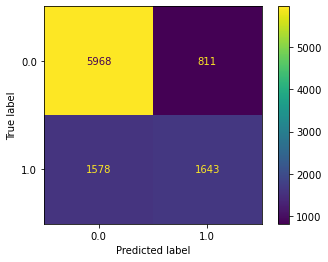

In [12]:
plot_confusion_matrix(knn, Ws_test, ys_test)

In [13]:
ys_predict = knn.predict(Ws_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(ys_test, ys_predict), 
                                                     recall_score(ys_test, ys_predict)))

Default threshold:
Precision: 0.6695,   Recall: 0.5101


# Logistic Regression


In [14]:
logit = LogisticRegression()
logit.fit(Ws_train, ys_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(Ws_train, ys_train)))
print("Test set: {:6.2f}%".format(100*logit.score(Ws_test, ys_test)))

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


The score for logistic regression is
Training:  65.99%
Test set:  65.99%


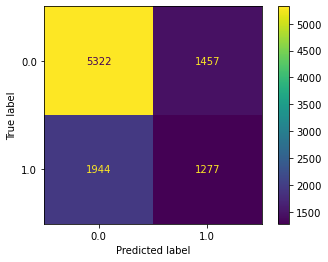

In [15]:
plot_confusion_matrix(logit, Ws_test, ys_test)

In [16]:
ys_predict = logit.predict(Ws_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(ys_test, ys_predict), 
                                                     recall_score(ys_test, ys_predict)))

Default threshold:
Precision: 0.4671,   Recall: 0.3965


# XGBoost

In [17]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=42, n_jobs=-1)
clf_xgb.fit(Ws_train, ys_train, verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(Ws_test, ys_test)])

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[0]	validation_0-aucpr:0.73852
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.75466
[2]	validation_0-aucpr:0.75879
[3]	validation_0-aucpr:0.76470
[4]	validation_0-aucpr:0.76939
[5]	validation_0-aucpr:0.77153
[6]	validation_0-aucpr:0.77448
[7]	validation_0-aucpr:0.77630
[8]	validation_0-aucpr:0.77678
[9]	validation_0-aucpr:0.77839
[10]	validation_0-aucpr:0.78034
[11]	validation_0-aucpr:0.78102
[12]	validation_0-aucpr:0.78231
[13]	validation_0-aucpr:0.78353
[14]	validation_0-aucpr:0.78350
[15]	validation_0-aucpr:0.78419
[16]	validation_0-aucpr:0.78524
[17]	validation_0-aucpr:0.78559
[18]	validation_0-aucpr:0.78639
[19]	validation_0-aucpr:0.78654
[20]	validation_0-aucpr:0.78714
[21]	validation_0-aucpr:0.78681
[22]	validation_0-aucpr:0.78729
[23]	validation_0-aucpr:0.78725
[24]	validation_0-aucpr:0.78721
[25]	validation_0-aucpr:0.78761
[26]	validation_0-aucpr:0.78732
[27]	validation_0-aucpr:0.78735
[28]	validation_0-aucpr:0.78771
[29]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [ ]:
params = {
    'max_depth': [3,4,5],
    'learning_rate': [0.1, 0.05, 0.01],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1, 3, 5]
}

kfold = KFold(n_splits=2)

best_xgb = GridSearchCV(
    clf_xgb, param_grid=params, cv=1, verbose=0, n_jobs=-1)

scores = cross_val_score(best_xgb, Ws, ys, scoring='r2', cv=kfold) 

In [ ]:
scores

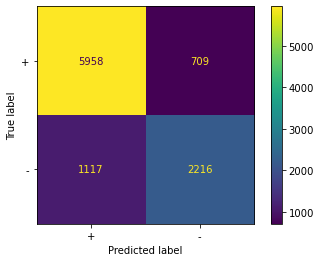

In [18]:
plot_confusion_matrix(clf_xgb,
                     Ws_test,
                     ys_test,
                     values_format='d',
                     display_labels=['+', '-'])

In [39]:
param_grid = {
    'max_depth': [3,4,5],
    'learning_rate': [0.1, 0.05, 0.01],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1, 3, 5]
}

optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                                         seed=42,
                                                         subsample=0.9,
                                                         colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=2,
    n_jobs=-1,
    cv=3
    )

optimal_params

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=42,
                                     subsample=0.9, tree_method=

# Random Forest Subsample

In [18]:
rf = RandomForestClassifier()
rf.fit(Ws_train, ys_train)
print("The r2 score for random forest is")
print("Training: {:6.2f}%".format(100*rf.score(Ws_train, ys_train)))
print("Test set: {:6.2f}%".format(100*rf.score(Ws_test, ys_test)))

<ipython-input-18-0897ec17a1ec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(Ws_train, ys_train)


The r2 score for random forest is
Training:  99.48%
Test set:  80.68%


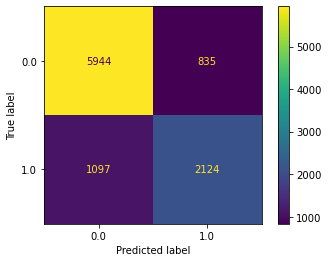

In [19]:
plot_confusion_matrix(rf, Ws_test, ys_test)

In [20]:
qs_predict = rf.predict(Ws_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(ys_test, ys_predict), 
                                                     recall_score(ys_test, ys_predict)))

Default threshold:
Precision: 0.4671,   Recall: 0.3965


# Random Forest


In [21]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(W_train, y_train)
print("The r2 score for random forest is")
print("Training: {:6.2f}%".format(100*rf.score(W_train, y_train)))
print("Test set: {:6.2f}%".format(100*rf.score(W_test, y_test)))

<ipython-input-21-8087620b27d4>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(W_train, y_train)


The r2 score for random forest is
Training:  97.55%
Test set:  81.41%


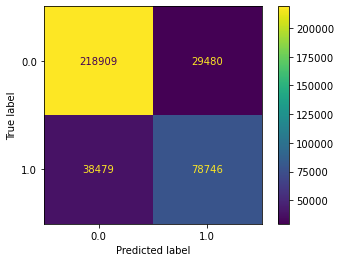

In [22]:
plot_confusion_matrix(rf, W_test, y_test)

In [25]:
y_predict = rf.predict(W_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

Default threshold:
Precision: 0.7276,   Recall: 0.6718


## Webapp Modeller

In [ ]:
def models(X,y,resampler):
    '''
    This function takes features, predictors, and a resampling method. It splits into train and test then
    cross validates on the training set using kfolds = 5. Train test split and kfolds are stratified to 
    ensure representation of classes in the test set. Output is the FBeta score for each model (beta = 4)
    prioritizing for recall. Also outputs ROC curve including all models
    ------
    Inputs: array, series, over_sampler (ADASYN, SMOTE, or RandomOverSampling)
    Outputs: dictionary, plot
    
    '''
    # 80:20 split holding out test set. Calling kfold
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify = y)
    kf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)

    # Dictionary to hold Results
    cv_results = defaultdict()
    cv_accuracy = defaultdict()
    test_results = defaultdict()

    # Get indices for split
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Couple models
    models = {'logreg':LogisticRegression(C = 1, penalty = 'l1', solver = 'newton-cg'), # See Grid Search CV
             'knn': KNeighborsClassifier(),
             'svc': svm.SVC(gamma = 'scale', probability = True),
             'naive': BernoulliNB(),
             'dectree': DecisionTreeClassifier(),
             'forrest': RandomForestClassifier(n_estimators = 100),} 
             #'xgboost': XGBClassifier()}

    for model_name, model in models.items():
        cv_results[model_name] = []
        cv_accuracy[model_name] = []
        
        for indices in kf.split(X_train, y_train):
            train_ind = indices[0]
            val_ind = indices[1]
            X_tr, y_tr = X_train[train_ind], y_train[train_ind]
            X_resampled_train, y_resampled_train = resampler(random_state=42).fit_sample(X_tr,y_tr)
            X_val, y_val = X_train[val_ind], y_train[val_ind]
            X_resampled_val, y_resampled_val = resampler(random_state=42).fit_sample(X_val, y_val)
            model.fit(X_resampled_train, y_resampled_train)
            y_pred = model.predict(X_val)
            cv_results[model_name].append(#'Precision Score {:.2f}'.format(precision_score(y_val, y_pred)),
                                      #'Recall Score: {:.2f}'.format(recall_score(y_val, y_pred)), 
                                      #'F1 Score: {:.2f}'.format(f1_score(y_val, y_pred)), 
                                    #'Training Accuracy:{:6.2f}%'.format(100*model.score(X_train, y_train)),
                                    #'Validation Accuracy: {:6.2f}%'.format(100*model.score(X_val, y_val)),
                                     fbeta_score(y_val, y_pred,4))

            cv_accuracy[model_name].append(100*model.score(X_val, y_val))
    fig = plt.figure(figsize=(10,10))    
    for model_name, model in models.items():
        cv_results[model_name] = 'Mean FBeta Score: {:.2f}'.format(statistics.mean(cv_results[model_name]))
        cv_accuracy[model_name] = 'Mean Val Accuracy: {:6.2f}%'.format(statistics.mean(cv_accuracy[model_name]))
        test_results[model_name] = 'Test Accuracy: {:6.2f}%'.format(100*model.score(X_test, y_test))
        fpr, tpr, threshold_curve = roc_curve(y_test, model.predict_proba(X_test)[::,1])
        plt.plot(fpr, tpr,lw=2, color =np.random.rand(3,), label = model_name)
        plt.legend()
        plt.plot([0,1],[0,1],c='violet',ls='--')
        plt.xlim([-0.05,1.05])
        plt.ylim([-0.05,1.05])
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC Curve for All Models');
    return cv_results, cv_accuracy, test_results